In [1]:
import HARK.ConsumptionSaving.ConsPortfolioFrameModel as cpfm
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm

from HARK.frame import Frame, draw_frame_model
import numpy as np

from HARK.rewards import (
    CRRAutility,
)

The `FrameAgentType` is an alternative way to specify a model.

The library contains a demonstration of this form of model, `ConsPortfolioFrameModel`, which is a replica of the `ConsPortfolioModel`.

This notebook compares the results of simulations of the two models.

In [2]:
pct = cpm.PortfolioConsumerType(T_sim=5000, AgentCount=200)
pct.cycles = 0

# Solve the model under the given parameters

pct.solve()
pct.track_vars += [
    "mNrm",
    "cNrm",
    "Share",
    "aNrm",
    "Risky",
    "Adjust",
    "PermShk",
    "TranShk",
    "bNrm",
    "who_dies",
]

pct.make_shock_history()
pct.read_shocks = True

pct.initialize_sim()

pct.simulate()

{'mNrm': array([[1.3750898 , 2.18787066, 1.47083041, ..., 1.3398794 , 1.1020387 ,
         1.53607636],
        [1.4879987 , 2.57065729, 1.64630759, ..., 1.38279705, 1.20535381,
         1.65688696],
        [2.11350808, 3.10337224, 1.95455687, ..., 1.66412985, 1.68565597,
         2.17361719],
        ...,
        [2.05657029, 4.14157884, 4.15183008, ..., 1.26605797, 3.29037898,
         2.46743314],
        [2.06854851, 4.12298161, 3.3868071 , ..., 1.47192969, 2.94856465,
         2.24509617],
        [2.07739624, 3.68862098, 3.10315448, ..., 1.62922637, 2.97558497,
         2.15285853]]),
 'cNrm': array([[0.91206535, 1.04922729, 0.93439143, ..., 0.90318141, 0.8320257 ,
         0.94829146],
        [0.93817255, 1.0939024 , 0.96942471, ..., 0.91395509, 0.86548385,
         0.9713206 ],
        [1.03977608, 1.14932132, 1.01833587, ..., 0.97261857, 0.97644685,
         1.0474355 ],
        ...,
        [1.03230997, 1.24656725, 1.24748268, ..., 0.88331788, 1.16766588,
         1.0823805

In [3]:
pcft = cpfm.PortfolioConsumerFrameType(T_sim=5000, AgentCount=200, read_shocks=True)

pcft.cycles = 0

# Solve the model under the given parameters
pcft.solve()

pcft.track_vars += [
    "mNrm",
    "cNrm",
    "Share",
    "aNrm",
    "Adjust",
    "PermShk",
    "TranShk",
    "bNrm",
    "U",
]

pcft.shock_history = pct.shock_history
pcft.newborn_init_history = pct.newborn_init_history

pcft.initialize_sim()

pcft.simulate()

Finished cycle #1 in 0.026999235153198242 seconds, solution distance = 100.0
Finished cycle #2 in 0.032006025314331055 seconds, solution distance = 51.348207181883055
Finished cycle #3 in 0.030508756637573242 seconds, solution distance = 17.087772635804413
Finished cycle #4 in 0.03099966049194336 seconds, solution distance = 8.522764942790388
Finished cycle #5 in 0.031005144119262695 seconds, solution distance = 5.0968728741369596
Finished cycle #6 in 0.031508684158325195 seconds, solution distance = 3.3840571487090756
Finished cycle #7 in 0.03600049018859863 seconds, solution distance = 2.4054860139035057
Finished cycle #8 in 0.0330052375793457 seconds, solution distance = 1.7940793244431212
Finished cycle #9 in 0.03554558753967285 seconds, solution distance = 1.3867304233120308
Finished cycle #10 in 0.03200054168701172 seconds, solution distance = 1.1015802993548025
Finished cycle #11 in 0.031003713607788086 seconds, solution distance = 0.8942354850378251
Finished cycle #12 in 0.0305

c:\users\alujan\github\alanlujan91\hark\HARK\core.py:551: UserWarning: The option for reading shocks was activated but the model requires state PermShkAgg, not contained in newborn_init_history.
  warn(
c:\users\alujan\github\alanlujan91\hark\HARK\core.py:551: UserWarning: The option for reading shocks was activated but the model requires state Rport, not contained in newborn_init_history.
  warn(
c:\users\alujan\github\alanlujan91\hark\HARK\core.py:551: UserWarning: The option for reading shocks was activated but the model requires state U, not contained in newborn_init_history.
  warn(
c:\users\alujan\github\alanlujan91\hark\HARK\core.py:743: UserWarning: The option for reading shocks was activated but the model requires state PermShkAgg, not contained in newborn_init_history.
  warn(
c:\users\alujan\github\alanlujan91\hark\HARK\core.py:743: UserWarning: The option for reading shocks was activated but the model requires state Rport, not contained in newborn_init_history.
  warn(
c:\u

{'mNrm': array([[1.49153665, 1.37355407, 0.72108687, ..., 1.53877809, 1.6304659 ,
         1.45281318],
        [1.57347404, 1.57347404, 1.69145662, ..., 1.50276864, 1.61542625,
         1.61542625],
        [1.52351467, 1.78042649, 1.45280927, ..., 1.52351467, 1.78042649,
         1.52351467],
        ...,
        [2.13988226, 1.92492264, 1.81226503, ..., 2.00095302, 2.00095302,
         1.81226503],
        [2.67745075, 2.76913855, 2.67745075, ..., 2.63020931, 2.44152133,
         2.55417893],
        [2.30190024, 2.49058823, 2.49058823, ..., 2.30190024, 2.37260564,
         2.45186476]]),
 'cNrm': array([[0.93895175, 0.93895175, 0.93895175, ..., 0.93895175, 0.93895175,
         0.93895175],
        [0.95572564, 0.95572564, 0.95572564, ..., 0.95572564, 0.95572564,
         0.95572564],
        [0.94566772, 0.94566772, 0.94566772, ..., 0.94566772, 0.94566772,
         0.94566772],
        ...,
        [1.04317491, 1.04317491, 1.04317491, ..., 1.04317491, 1.04317491,
         1.0431749

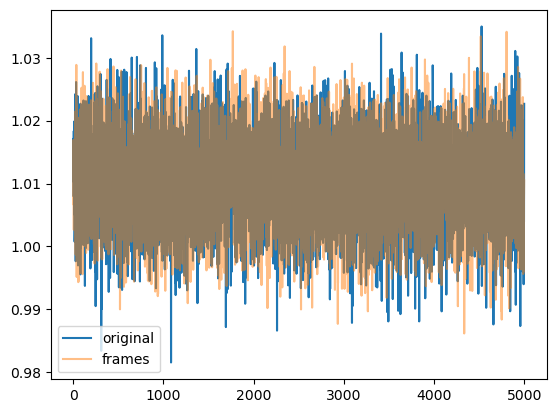

In [4]:
import matplotlib.pyplot as plt

plt.plot(range(5000), pct.history["PermShk"].mean(axis=1), label="original")
plt.plot(range(5000), pcft.history["PermShk"].mean(axis=1), label="frames", alpha=0.5)
plt.legend()

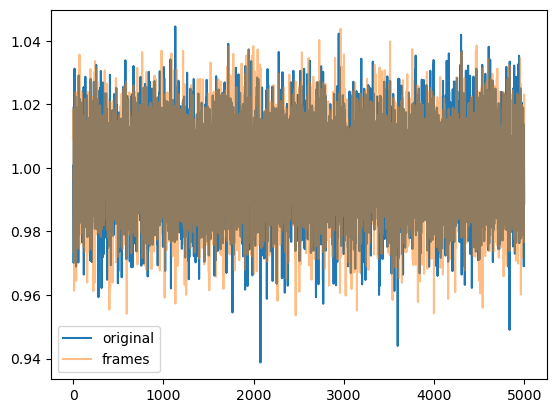

In [5]:
plt.plot(range(5000), pct.history["TranShk"].mean(axis=1), label="original")
plt.plot(range(5000), pcft.history["TranShk"].mean(axis=1), label="frames", alpha=0.5)
plt.legend()

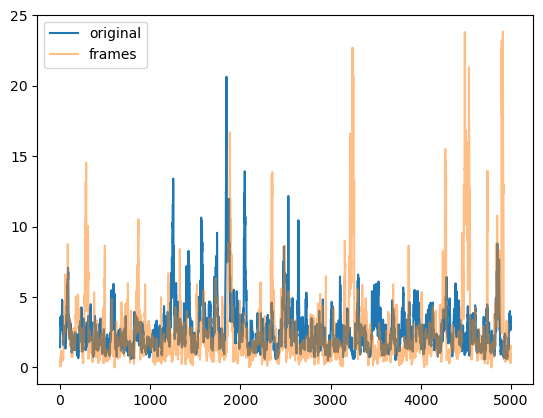

In [6]:
plt.plot(range(5000), pct.history["bNrm"].mean(axis=1), label="original")
plt.plot(range(5000), pcft.history["bNrm"].mean(axis=1), label="frames", alpha=0.5)
plt.legend()

In [7]:
# plt.plot(range(5000), pct.history['Risky'].mean(axis=1), label = 'original')
# plt.plot(range(5000), pcft.history['Risky'].mean(axis=1), label = 'frames', alpha = 0.5)
# plt.legend()

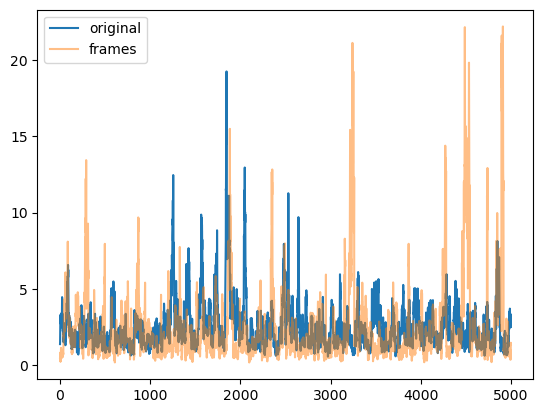

In [8]:
plt.plot(range(5000), pct.history["aNrm"].mean(axis=1), label="original")
plt.plot(range(5000), pcft.history["aNrm"].mean(axis=1), label="frames", alpha=0.5)
plt.legend()

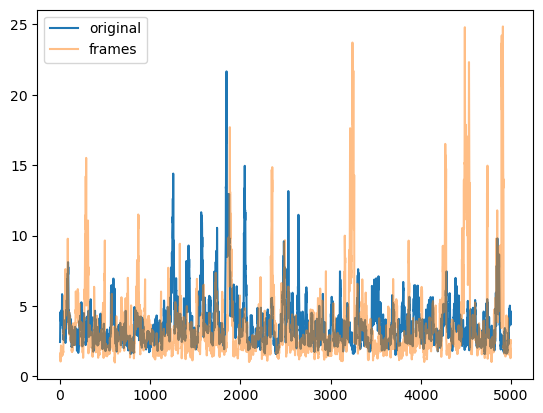

In [9]:
plt.plot(range(5000), pct.history["mNrm"].mean(axis=1), label="original")
plt.plot(range(5000), pcft.history["mNrm"].mean(axis=1), label="frames", alpha=0.5)
plt.legend()

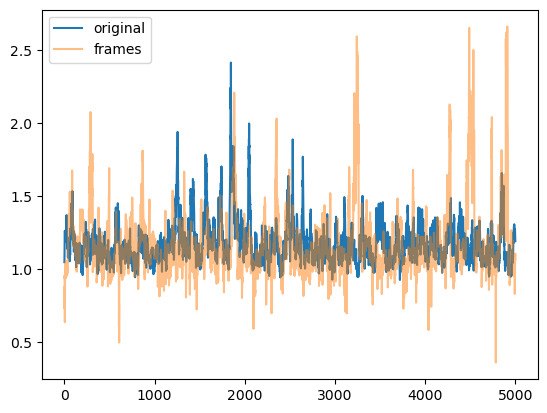

In [10]:
plt.plot(range(5000), pct.history["cNrm"].mean(axis=1), label="original")
plt.plot(range(5000), pcft.history["cNrm"].mean(axis=1), label="frames", alpha=0.5)
plt.legend()

**TODO**: Handly Risky as an aggregate value.

In [11]:
# pct.history['Risky'][:3, :3]

In [12]:
# pcft.history['Risky'][:3, :3]

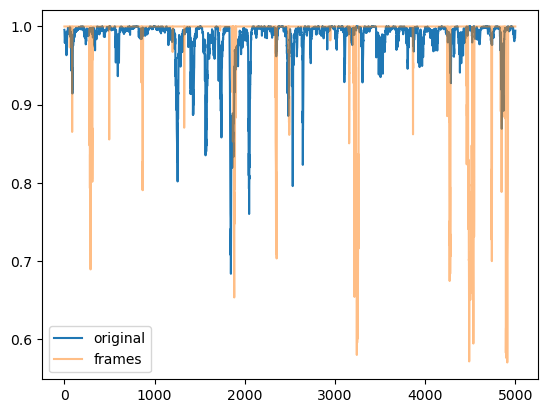

In [13]:
plt.plot(range(5000), pct.history["Share"].mean(axis=1), label="original")
plt.plot(range(5000), pcft.history["Share"].mean(axis=1), label="frames", alpha=0.5)
plt.legend()

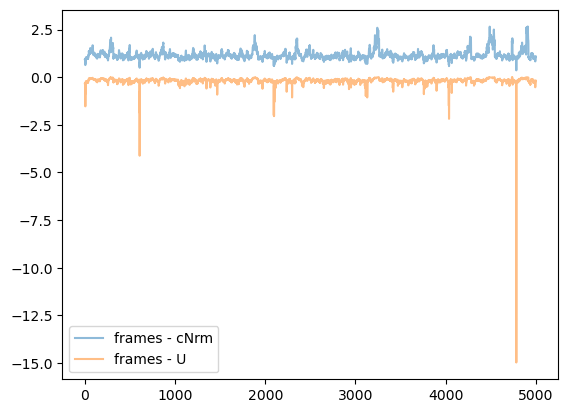

In [14]:
plt.plot(
    range(5000), pcft.history["cNrm"].mean(axis=1), label="frames - cNrm", alpha=0.5
)
plt.plot(range(5000), pcft.history["U"].mean(axis=1), label="frames - U", alpha=0.5)
plt.legend()

In [15]:
pcft.history["U"]

array([[-0.32163767, -0.32163767, -0.32163767, ..., -0.32163767,
        -0.32163767, -0.32163767],
       [-0.29964502, -0.29964502, -0.29964502, ..., -0.29964502,
        -0.29964502, -0.29964502],
       [-0.31259768, -0.31259768, -0.31259768, ..., -0.31259768,
        -0.31259768, -0.31259768],
       ...,
       [-0.2111113 , -0.2111113 , -0.2111113 , ..., -0.2111113 ,
        -0.2111113 , -0.2111113 ],
       [-0.16738868, -0.16738868, -0.16738868, ..., -0.16738868,
        -0.16738868, -0.16738868],
       [-0.19567764, -0.19567764, -0.19567764, ..., -0.19567764,
        -0.19567764, -0.19567764]])

In [16]:
pcft.history["U"].mean(axis=1)

array([-0.32163767, -0.29964502, -0.31259768, ..., -0.2111113 ,
       -0.16738868, -0.19567764])

In [17]:
pcft.history["U"][0, :]

array([-0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32

In [18]:
pcft.history["cNrm"][0, :]

array([0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895175,
       0.93895175, 0.93895175, 0.93895175, 0.93895175, 0.93895

In [19]:
pcft.parameters["CRRA"]

5.0

In [20]:
CRRAutility(pcft.history["cNrm"][0, :], 5)

array([-0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32163767,
       -0.32163767, -0.32163767, -0.32163767, -0.32163767, -0.32

# Visualizing the Transition Equations

Note that in the HARK `ConsIndShockModel`, from which the `ConsPortfolio` model inherits, the aggregate permanent shocks are considered to be portions of the permanent shocks experienced by the agents, not additions to those idiosyncratic shocks. Hence, they do not show up directly in the problem solved by the agent. This explains why the aggregate income levels are in a separarte component of the graph.

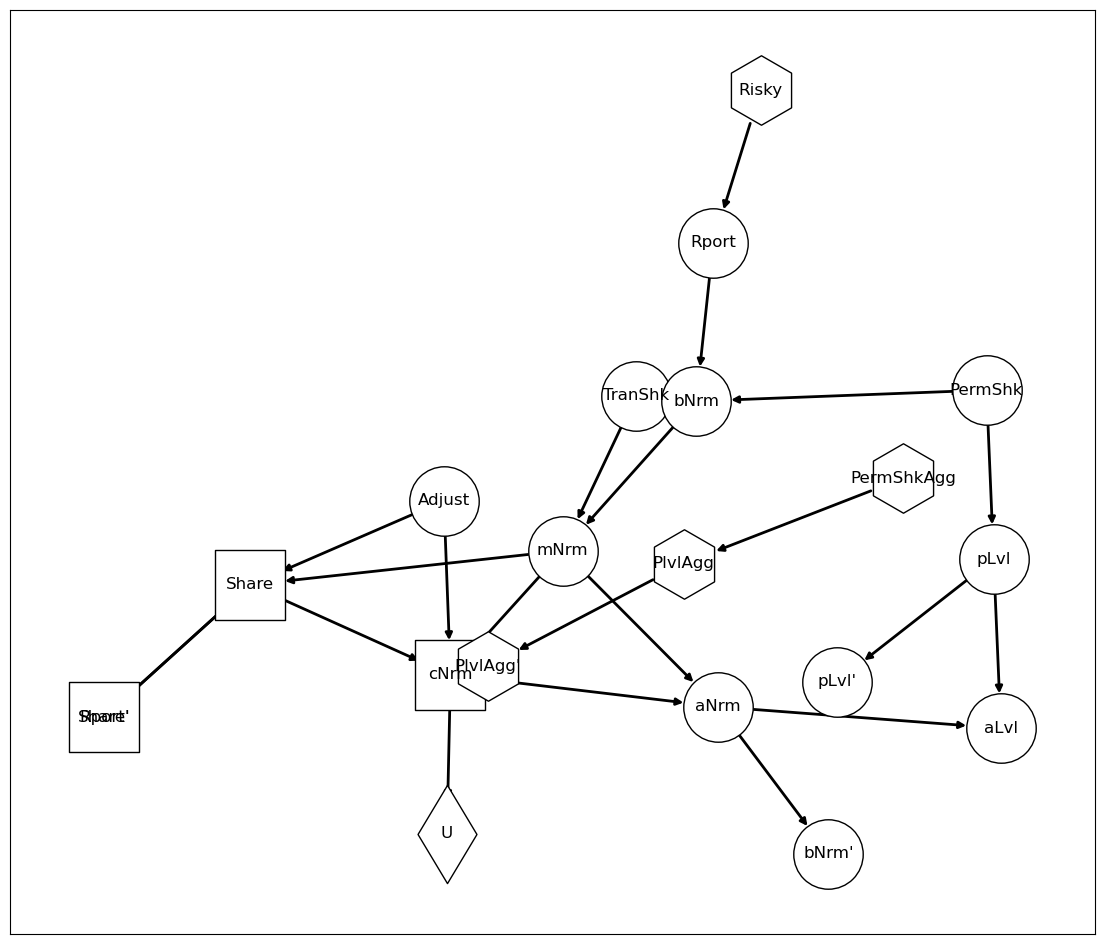

In [21]:
draw_frame_model(pcft.model, figsize=(14, 12))

# Building the Solver [INCOMPLETE]

Preliminery work towards a generic solver for FramedAgentTypes.

In [22]:
controls = [frame for frame in pcft.frames.values() if frame.control]

In [23]:
def get_expected_return_function(control: Frame):
    # Input: a control frame
    # Returns: function of the control variable (control frame target)
    #      that returns the expected return, which is
    #          the sum of:
    #              - direct rewards
    #              - expected value of next-frame states (not yet implemented)
    #

    rewards = [child for child in control.children if child.reward]
    expected_values = []  # TODO

    ## note: function signature is what's needed for scipy.optimize
    def expected_return_function(x, *args):
        ##   returns the sum of
        ##     the reward functions evaluated in context of
        ##       - parameters
        ##       - the control variable input

        # x - array of inputs, here the control frame target
        # args - a tuple of other parameters needed to complete the function

        expected_return = 0

        for reward in rewards:
            ## TODO: figuring out the ordering of `x` and `args` needed for multiple downstream scopes

            local_context = {}

            # indexing through the x and args values
            i = 0
            num_control_vars = None

            # assumes that all frame scopes list model variables first, parameters later
            # should enforce or clarify at the frame level.
            for var in reward.scope:
                if var in control.target:
                    local_context[var] = x[i]
                    i = i + 1
                elif var in pcft.parameters:
                    if num_control_vars is None:
                        num_control_vars = i

                    local_context[var] = args[i - num_control_vars]
                    i = i + 1

            # can `self` be implicit here?
            expected_return += reward.transition(reward, **local_context)

        return expected_return

    return expected_return_function

In [24]:
def optimal_policy_function(control: Frame):

    erf = get_expected_return_function(control)
    constraints = (
        control.constraints
    )  ## these will reference the context of the control transition, including scope

    ## Returns function:
    ##   input: control frame scope
    ##   output: result of scipy.optimize of the erf with respect to constraints
    ##           getting the optimal input (control variable) value
    return func

In [25]:
def approximate_optimal_policy_function(control, grid):
    ## returns a new function:
    ##   that is an interpolation over optimal_policy_function
    ##   over the grid

    return func